# Classification Data Preparation
**Mudgee NSW - Change Detection Jan 2005 to Jan 2024**

Author: Michael Dear, May 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Feb 2005', 'Feb 2024']

## Step 2: Classification

### Ground-truth Points (GTP)
https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe

In [8]:
# Add current date-time to filename to prevent overwriting existing GTPs
import time
timestr = time.strftime("%Y%m%d_%H%M%S")

for period in periods:
    df = ds.sel(period=period).to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df[['period']+X_vars], geometry=gpd.points_from_xy(df.x,df.y))
    gdf[y_var] = '' # Add a class variable
    gdf = gdf.set_crs(crs)
    gdf = gpd.sjoin(gdf, poly, how='inner') # Limit to polygon
    gdf = gdf.sample(np.round(gdf.shape[0]*0.1).astype(np.int16), random_state=random_state) # Sample to reduce file size
    gdf = gdf[['period']+X_vars+y_var+['geometry']] # Drop unwanted columns
    gdf.to_file(vector_dir+study_area_abbrev+'_'+period+'_'+timestr+'_GTP.geojson', driver='GeoJSON')

del df, gdf # Clean up

1. Open the exported points file in QGIS and create a sample of labelled points for each class.
2. Rename the completed GTP files to `vector_dir+study_area_abbrev+'_'+periods[i]+'_GTP_final.geojson'`

In [273]:
# Read the point geometries back in
gtp = [gpd.read_file(vector_dir+study_area_abbrev+'_'+period+'_GTP_final.geojson') for period in periods]

In [274]:
# Drop the empty rows
gtp = [gdf[gdf['class'].notnull()] for gdf in gtp]

for gdf in gtp:
    print(gdf.head())

         period      NDVI         class  nbart_red  nbart_green  nbart_blue  \
0  Aug-Nov 2004  0.614735  Ridge Forest      444.5        337.0       177.0   
1  Aug-Nov 2004  0.614735  Ridge Forest      444.5        337.0       177.0   
2  Aug-Nov 2004  0.602950  Ridge Forest      471.0        429.0       227.5   
3  Aug-Nov 2004  0.602950  Ridge Forest      471.0        429.0       227.5   
4  Aug-Nov 2004  0.704138  Ridge Forest      416.5        379.5       165.5   

   nbart_nir                          geometry  
0     1863.0  POINT (1629450.000 -3675050.000)  
1     1863.0  POINT (1629450.000 -3675050.000)  
2     1901.5  POINT (1629050.000 -3668650.000)  
3     1901.5  POINT (1629050.000 -3668650.000)  
4     2399.0  POINT (1629650.000 -3672950.000)  
         period      NDVI          class  nbart_red  nbart_green  nbart_blue  \
0  Aug-Nov 2022  0.760108  Sparse Forest      310.0        294.5       153.0   
1  Aug-Nov 2022  0.760108  Sparse Forest      310.0        294.5       

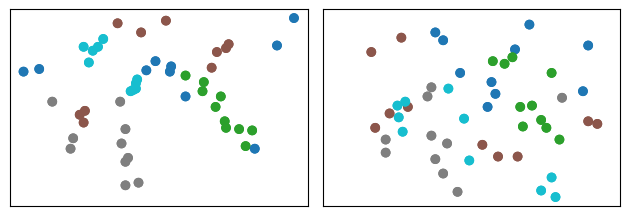

In [11]:
# Visualise the GTPs
fig, axes = plt.subplots(1,2, sharey=True, sharex=True)

for i, gdf in enumerate(gtp):
    gdf.plot(ax=axes[i], column='class')
    axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()

### NDVI Classification

The following are typical NDVI thresholds based on the literature. These will need to be adjusted for each period from the results of the GTP analysis. 
|Class Number|Class Name|Class Description|Threshold|
|:-:|:-|:-|:-:|
|1|Water|Deep water bodies e.g. lakes, rivers|$$\text{NDVI} \lt 0$$|
|2|Bare|Bare ground|$$0 \le \text{NDVI} \lt 0.15$$|
|3|Sparse|Sparse vegetation e.g. scattered shrubs, patchy grass|$$0.15 \le \text{NDVI} \lt 0.5$$|
|4|Medium-density|Medium-density vegetation e.g. woodland; post-fire regrowth|$$0.5 \le \text{NDVI} \lt 0.8$$|
|5|High-density|Dense vegetation e.g. forest|$$\text{NDVI} \ge 0.8$$|
|6|Masked|No data|nan|

The thresholds were derived from the following sources:

* [Map Information - Normalised Difference Vegetation Index: Australian Bureau of Meterology](http://www.bom.gov.au/climate/austmaps/about-ndvi-maps.shtml)
* [NDVI, the Foundation for Remote Sensing Phenology : USGS](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

#### GTP Analysis

In [255]:
# Summarise by Class
for gdf in gtp:
    print(gdf.groupby('class').agg({'NDVI':['min','max','mean','median']}))

           NDVI                              
            min       max      mean    median
class                                        
0      0.337499  0.491186  0.406593  0.405956
1      0.082474  0.430001  0.313451  0.384655
2      0.398991  0.665198  0.529239  0.521958
3      0.573622  0.723865  0.625849  0.605657
4      0.705184  0.834696  0.762751  0.758880
           NDVI                              
            min       max      mean    median
class                                        
0      0.397009  0.559463  0.473888  0.470658
1     -0.002503  0.414845  0.255645  0.317675
2      0.640822  0.760108  0.699701  0.695091
3      0.626292  0.753412  0.685661  0.676756
4      0.718979  0.845529  0.788176  0.788265


#### Create the NDVI classification dataset
<a id='create_classification'></a>

In [37]:
# Function to make threshold classification variable
# See https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html for np.digitize
# See https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html for assigning numpy array to a dataset

# Needed to set the order of the dims explicitly in this case - not the same as ds.dims
def make_class_var(ds, class_bins, var, newvar):
    class_arr = np.empty(ds[var].values.shape)
    
    class_arr = [np.digitize(ds[var].sel(period=period), class_bins[i]).astype(np.int16) 
     for i, period in enumerate(ds.period.values)]

    # Subtract 1 from class values to align with other classification methods
    class_arr = np.array(class_arr)-1
    
    # ds = ds.assign({newvar: (('period','y','x'), class_arr)})
    # return ds
    
    return class_arr

In [54]:
# Use mean or median for first n-2 classes
# Use the minimum of the nth class as the upper bound of the (n-1)th class
# No upper bound required for the nth class (it is np.inf)
NDVI_class_bins = [
    [-np.inf, 0.175, 0.5, 0.76, np.inf],
    [-np.inf, 0.175, 0.55, 0.775, np.inf]
]

In [55]:
class_arr = make_class_var(ds, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds = ds.assign({'NDVI_Class': (('period','y','x'), class_arr)})

In [56]:
# Check unique classes present
np.unique(ds.NDVI_Class)

array([0, 1, 2, 3], dtype=int16)

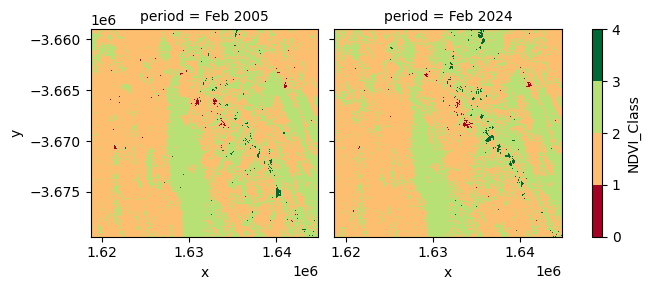

In [57]:
# Plot of NDVI_Class
ds.NDVI_Class.plot(col='period', 
                   cmap='RdYlGn', 
                   levels = np.arange(len(np.unique(ds.NDVI_Class))+1)
                  )

### Kmeans Classification
Based on https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

#### Create the normalised dataframe

In [10]:
# Select the variables to use in the classification
km_vars = [list(ds.data_vars.keys())[i] for i in [5,6,7]]

df = ds[km_vars].to_dataframe().reset_index(['x','y'], drop=True).drop('spatial_ref', axis=1)

from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

x = df[km_vars].values # returns a numpy array
x_norm = scaler.fit_transform(x)
df[km_vars] = x_norm
df.head()

,NDVI,NDVI_mean,NDVI_sd
period,,,
Feb 2005,0.309249,1.126659,-1.152850
Feb 2005,0.886289,1.525353,-1.285098
Feb 2005,-1.496082,-1.023953,-0.322835
Feb 2005,-1.198183,-0.868880,-0.658799
Feb 2005,-0.922433,0.042401,-0.330588


#### Check for missing values

In [11]:
df.isnull().sum()

NDVI         0
NDVI_mean    0
NDVI_sd      0
dtype: int64

#### Determine best K
See https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

In [15]:
from sklearn.cluster import KMeans

In [34]:
# Array to hold the final classifications
km_arrs = [[] for i in [0,1]]

In [33]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [28]:
ks = np.arange(1,10)

# Set random_state for reproducibility
km = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [29]:
scores = [[k.fit(df.loc[period]).score(df.loc[period]) for k in km] for period in periods]

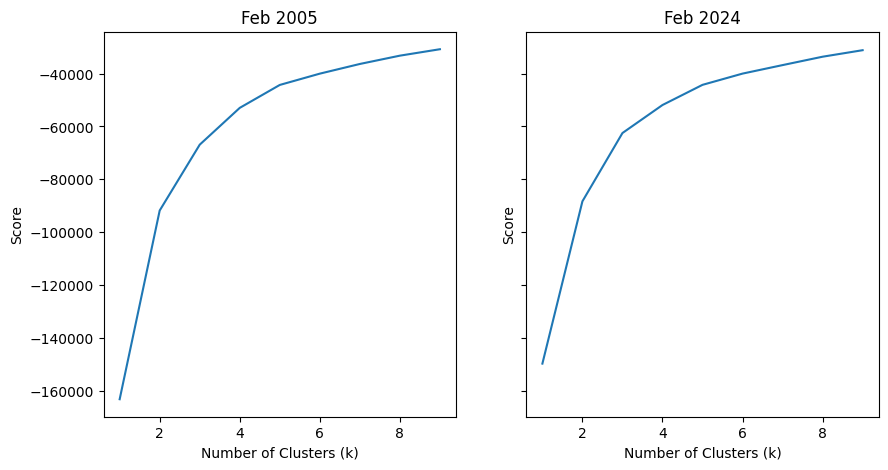

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for i, period in enumerate(periods):
    axes[i].plot(ks, scores[i])
    axes[i].set_xlabel('Number of Clusters (k)')
    axes[i].set_ylabel('Score')
    axes[i].set_title(period)

----

#### Option 1: Fit on Period 0; predict on Period 1

In [312]:
km = KMeans(n_clusters=5, random_state = random_state)
km_arrs[0] = (km.fit(df.loc[periods[0]])
        .labels_
        .reshape(w,l)
       )

In [313]:
km_arrs[1] = (km.predict(df.loc[periods[1]])
        .reshape(w,l)
       )

----

#### Option 2: Fit on both periods separately

In [64]:
ks = [4,4]
for i, k in enumerate(ks):
    km = KMeans(n_clusters=k, random_state = random_state)
    km_arrs[i] = km.fit(df.loc[periods[i]]).labels_.reshape(w,l)

----

#### Either Option: Plot to check the data

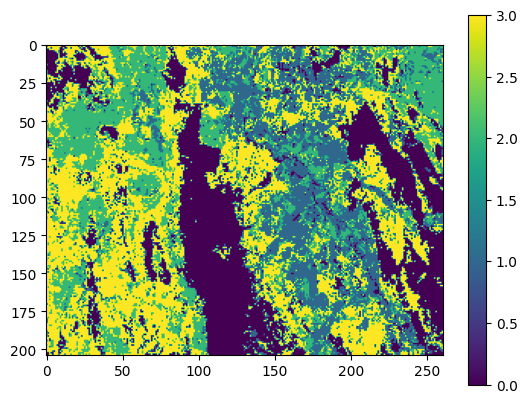

In [164]:
plt.imshow(km_arrs[0])
plt.colorbar()

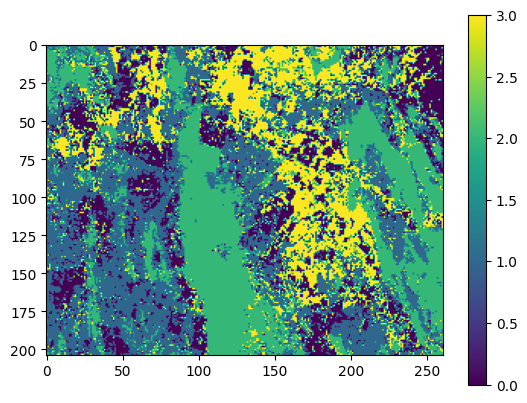

In [165]:
plt.imshow(km_arrs[1])
plt.colorbar()

#### Add the classification data to the dataset

In [65]:
# Convert to int16
km_arrs = np.array(km_arrs, dtype=np.int16)

In [66]:
ds = ds.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

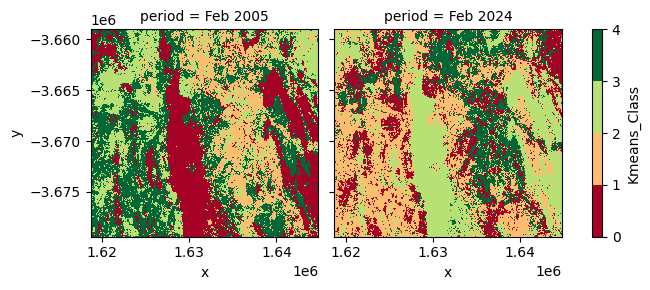

In [67]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

#### Re-code Classes (Optional)


In [68]:
old_vals = np.array(km_arrs)

In [69]:
new_vals = np.empty(old_vals.shape)
new_vals.shape

(2, 204, 261)

In [90]:
# Use the same re-code values for both periods if using Option 1.
recode = (
    [(0,2),(1,3),(2,0),(3,1)],
    [(0,0),(1,1),(2,2),(3,3)]
)

In [91]:
for i in [0,1]:
    for j in np.arange(len(np.unique(old_vals[i]))):
        new_vals[i][old_vals[i]==recode[i][j][0]] = recode[i][j][1]

In [92]:
ds.Kmeans_Class.values = new_vals

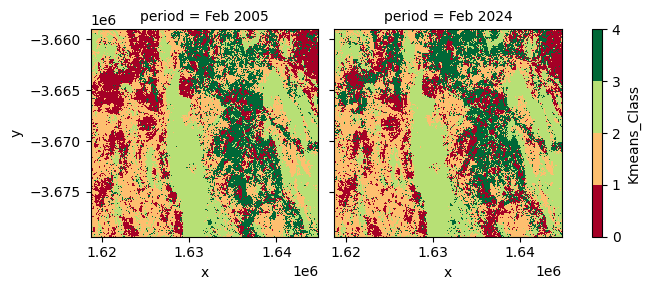

In [93]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

## Step 3: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [13]:
rf_vars = [list(ds.data_vars.keys())[i] for i in [5,6,7]]

In [278]:
X = [gdf[rf_vars] for gdf in gtp]
y = [gdf[y_var] for gdf in gtp]

In [279]:
for i in [0,1]:
    print(X[i][:5])
    print(y[i][:5])

   nbart_red  nbart_green  nbart_blue  nbart_nir
0      444.5        337.0       177.0     1863.0
1      444.5        337.0       177.0     1863.0
2      471.0        429.0       227.5     1901.5
3      471.0        429.0       227.5     1901.5
4      416.5        379.5       165.5     2399.0
   class
0      3
1      3
2      3
3      3
4      3
   nbart_red  nbart_green  nbart_blue  nbart_nir
0      310.0        294.5       153.0     2274.5
1      310.0        294.5       153.0     2274.5
2     1272.5        972.5       578.0     2460.5
3     1272.5        972.5       578.0     2460.5
4      382.0        443.0       204.0     2570.5
   class
0      2
1      2
2      0
3      0
4      2


#### Basic RF

In [280]:
for i in [0,1]:
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(periods[i])
    print('============')
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Aug-Nov 2004
Accuracy: 1.0

Feature Importance
nbart_green    0.291050
nbart_blue     0.258008
nbart_nir      0.229355
nbart_red      0.221587
dtype: float64

Confusion matrix
[[5 0 0 0 0]
 [0 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 6]]

Aug-Nov 2022
Accuracy: 1.0

Feature Importance
nbart_nir      0.278674
nbart_green    0.264020
nbart_blue     0.245073
nbart_red      0.212233
dtype: float64

Confusion matrix
[[7 0 0 0 0]
 [0 3 0 0 0]
 [0 0 1 0 0]
 [0 0 0 3 0]
 [0 0 0 0 6]]



#### RF With Hyperparameter Tuning

In [228]:
# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(X_train, y_train)

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Aug-Nov 2004
Accuracy: 1.0

Feature Importance
nbart_green    0.299678
nbart_blue     0.261814
nbart_nir      0.228207
nbart_red      0.210301
dtype: float64

Confusion matrix
[[3 0 0 0 0]
 [0 5 0 0 0]
 [0 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 6]]

Aug-Nov 2022
Accuracy: 1.0

Feature Importance
nbart_green    0.284351
nbart_nir      0.280958
nbart_blue     0.230576
nbart_red      0.204115
dtype: float64

Confusion matrix
[[3 0 0 0 0]
 [0 7 0 0 0]
 [0 0 1 0 0]
 [0 0 0 3 0]
 [0 0 0 0 6]]



#### Predictions for each period

In [281]:
rf_arrs = [[] for i in [0,1]]

In [282]:
w = list(ds.sizes.values())[1]
l = list(ds.sizes.values())[2]

In [286]:
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

#### Add the classification data to the dataset

In [287]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

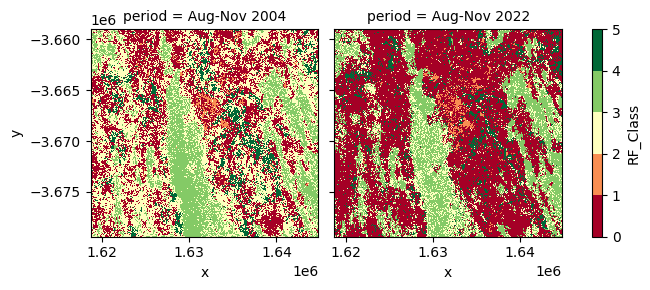

In [288]:
ds.RF_Class.plot(col='period', 
                 levels=np.arange(len(np.unique(ds.RF_Class))+1),
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [94]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [96]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )